<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/modeling_and_prediction_Quantile_LSTM_SeperateHeads_KerasTuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## -------------- 1) Google-Drive & Installationen --------------

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow
!pip install keras
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.4 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import keras_tuner as kt

## -------------- 2) Daten laden und vorbereiten --------------

## Funktionen:

In [4]:
# Pfade
name_Messwerte = 'Messdaten_CAMS_GHI.csv'
name_Vorhersage = 'Vorhersagedaten_CAMS_VarIdx.csv'
folder_import = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'

model_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/full_model.keras'
weights_path = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_weights.weights.h5'
testdata_path_X = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_testdata_X.csv'
testdata_path_Y = '/content/drive/My Drive/Colab_Notebooks/LSTM_Model/model_testdata_Y.csv'
text_file_path = "/content/drive/MyDrive/Colab_Notebooks/LSTM_Model/model_results.txt"

In [5]:
# Daten laden
df_Messdaten = pd.read_csv(folder_import + name_Messwerte)
df_Vorhersage = pd.read_csv(folder_import + name_Vorhersage)

# Zeitspalten konvertieren und zusammenführen
df_Messdaten['Datetime'] = pd.to_datetime(df_Messdaten['Datetime'])
df_Vorhersage['Datetime'] = pd.to_datetime(df_Vorhersage['Datetime'])

# Hier ggf. Merge, falls du das brauchst
# df = pd.merge(df_Messdaten, df_Vorhersage, on="Datetime", how="inner")
# Für das Beispiel nimmst du offenbar nur df_Messdaten:
df = df_Messdaten.copy()

## -------------- 3) Hilfsfunktionen --------------

In [6]:
def quantile_loss(q, y_true, y_pred):
    """Berechnet den Pinball Loss für mehrere Quantile."""
    e = y_true - y_pred
    return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e), axis=-1)  # Reduziere entlang der letzten Achse

In [7]:
def multi_quantile_loss(y_true, y_pred):
    losses = []
    for i, q in enumerate(quantiles):
        losses.append(quantile_loss(q, y_true[:, i], y_pred[:, i]))
    return tf.reduce_mean(losses)

## -------------- 4) Modell- und Trainings-Konfiguration --------------

In [8]:
model_name = "LSTM_mit_Vorhersagewerten_1Step"
columns_X = ['Clear_sky_GHI', 'Clear_sky_BHI', 'GHI', 'BHI', 'Temp', 'SZA', 'time_sin', 'time_cos', 'date_sin', 'date_cos']
columns_y = ['UVI']
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]

## Config:

In [9]:
# Standardwerte - werden gleich durch Keras Tuner ersetzt
model_config = {
    "units_1": 64,
    "units_2": 32,
    "dropout_rate": 0.1,
    "final_activation": "linear"
}

In [10]:
training_config = {
    "loss": multi_quantile_loss,
    "optimizer": "adam",
    "metrics": [
        "mse",
        "mae",
        "mape",
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
}

In [11]:
fit_config = {
    "epochs": 5,
    "batch_size": 64,
    "sequence_length": 64
}

## Setup:

In [12]:
total_length = len(df)
train_size   = round(total_length * 0.80)
val_size     = round(total_length * 0.10)
test_size    = total_length - train_size - val_size  # restliche 10%

# Skaliere X und Y separat (immer zuerst nur auf dem Trainingsbereich fitten!)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Trainingsdaten
train_df = df.iloc[:train_size].copy()
train_df[columns_X] = scaler_X.fit_transform(train_df[columns_X])
train_df[columns_y] = scaler_y.fit_transform(train_df[columns_y])

# Validierungsdaten
val_df = df.iloc[train_size : train_size + val_size].copy()
val_df[columns_X] = scaler_X.transform(val_df[columns_X])
val_df[columns_y] = scaler_y.transform(val_df[columns_y])

# Testdaten
test_df = df.iloc[train_size + val_size :].copy()
test_df[columns_X] = scaler_X.transform(test_df[columns_X])
test_df[columns_y] = scaler_y.transform(test_df[columns_y])

# Kontrolle
print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)

Train: (77386, 26)
Val: (9673, 26)
Test: (9673, 26)


In [13]:
def create_sequence_OneStepAhead(X, y, seq_length):
    sequences = []
    labels = []
    for stop_idx in range(seq_length, len(X)-1):
        x_seq = X.iloc[stop_idx-seq_length:stop_idx].values
        y_label = y.iloc[stop_idx + 1]  # => label ist der nächste Zeitschritt
        sequences.append(x_seq)
        labels.append(y_label)
    return np.array(sequences), np.array(labels)

In [14]:
sequence_len = fit_config["sequence_length"]
X_train_seq, y_train_seq = create_sequence_OneStepAhead(train_df[columns_X], train_df[columns_y], sequence_len)
X_val_seq,   y_val_seq   = create_sequence_OneStepAhead(val_df[columns_X],   val_df[columns_y],   sequence_len)
X_test_seq,  y_test_seq  = create_sequence_OneStepAhead(test_df[columns_X],  test_df[columns_y],  sequence_len)

# y-Werte für alle Quantile kaskadieren
y_train_seq = np.tile(y_train_seq, (1, len(quantiles)))
y_val_seq   = np.tile(y_val_seq,   (1, len(quantiles)))
y_test_seq  = np.tile(y_test_seq,  (1, len(quantiles)))

print("X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)
print("X_val_seq:", X_val_seq.shape,     "y_val_seq:",   y_val_seq.shape)
print("X_test_seq:", X_test_seq.shape,   "y_test_seq:",  y_test_seq.shape)

X_train_seq: (77321, 64, 10) y_train_seq: (77321, 5)
X_val_seq: (9608, 64, 10) y_val_seq: (9608, 5)
X_test_seq: (9608, 64, 10) y_test_seq: (9608, 5)


In [15]:
# Liste pro Quantil
y_train_list = [y_train_seq[:, i] for i in range(len(quantiles))]
y_val_list   = [y_val_seq[:,   i] for i in range(len(quantiles))]
y_test_list  = [y_test_seq[:,  i] for i in range(len(quantiles))]

## Model Definition:

In [16]:
def build_model(hp):
    """
    Definiert das Modell mit einem Hyperparameter-Suchraum:
      - units_1 (Größe der ersten LSTM-Schicht)
      - units_2 (Größe der zweiten LSTM-Schicht)
      - dropout_rate
      - final_activation
      - optional: learning_rate
    """
    # ------------------- Hyperparameter definieren -------------------
    units_1 = hp.Choice('units_1', values=[32, 64, 128], default=64)
    units_2 = hp.Choice('units_2', values=[16, 32, 64], default=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1, default=0.1)

    # Du kannst hier auch z. B. die Aktivierung tunen
    final_activation = hp.Choice('final_activation', ['linear', 'relu'], default='linear')

    # Falls du die Learning Rate tunen möchtest (optional)
    # learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log', default=1e-3)

    # ------------------- Modellaufbau -------------------
    main_input = Input(shape=(sequence_len, len(columns_X)), name="main_input")
    x = LSTM(units_1, return_sequences=True)(main_input)
    x = Dropout(dropout_rate)(x)
    x = LSTM(units_2, return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)

    # Separate Ausgänge pro Quantil
    heads = []
    for i, q in enumerate(quantiles):
        out = Dense(1, activation=final_activation, name=f"quantile_{int(q*100)}")(x)
        heads.append(out)

    model = Model(inputs=main_input, outputs=heads)

    # Dictionary für Verluste
    losses = {}
    for i, q in enumerate(quantiles):
        key_name = f"quantile_{int(q*100)}"
        # Wir nutzen denselben quantile_loss wie zuvor.
        losses[key_name] = (lambda y_true, y_pred, q=q: quantile_loss(q, y_true, y_pred))

    # Dictionary für Metriken
    metrics_dict = {}
    for q in quantiles:
        key_name = f"quantile_{int(q*100)}"
        metrics_dict[key_name] = training_config["metrics"]

    # Modell kompilieren
    model.compile(
        # optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        optimizer=training_config["optimizer"],
        loss=losses,
        metrics=metrics_dict
    )

    return model


## -------------- 8) Keras Tuner initialisieren --------------

- Wichtig: Da wir ein Multi-Output-Modell haben, sollten wir einen gemeinsamen Loss (val_loss) als Ziel nehmen.
- Keras Tuner nimmt standardmäßig 'val_loss' als Zielmetrik, wenn objective='val_loss' angegeben wird.
- (Alternativ: objective=kt.Objective("val_quantile_50_loss", direction="min") für Fokussierung auf Q=0.5)
- Hier als Beispiel: 'val_loss' = Summe aller quantile-Losses.

In [17]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_loss',   # Optimiert den gemittelten/aggregierten Loss über alle Outputs
    max_trials=5,           # Wie viele unterschiedliche HP-Kombinationen getestet werden
    executions_per_trial=1, # Mehrfachausführung pro Trial für stabilere Ergebnisse, aber längere Laufzeiten
    overwrite=True,
    directory='/content/drive/My Drive/Colab_Notebooks/LSTM_Model/kerastuner_dir',
    project_name='lstm_quantiles_tuning'
)

In [18]:
# -------------- 9) Hyperparameter-Suche starten --------------
# Wir übergeben X_train_seq und y_train_list (Liste von 5 Arrays),
# sowie X_val_seq und y_val_list als Validation.

tuner.search(
    X_train_seq,
    y_train_list,
    epochs=fit_config["epochs"],        # du kannst die Epochenzahl fürs Tuning reduzieren, um schneller zu sein
    batch_size=fit_config["batch_size"],
    validation_data=(X_val_seq, y_val_list),
    verbose=1
)

Trial 5 Complete [00h 03m 20s]
val_loss: 0.07074758410453796

Best val_loss So Far: 0.0672788992524147
Total elapsed time: 00h 16m 32s


In [19]:
# -------------- 10) Auswertung der besten Modelle --------------
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Beste Hyperparameter-Kombination laut Tuner:")
for param in best_hps.values.keys():
    print(param, ":", best_hps.get(param))

# Bestes Modell laden
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Beste Hyperparameter-Kombination laut Tuner:
units_1 : 128
units_2 : 32
dropout_rate : 0.1
final_activation : linear


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ main_input (InputLayer)   │ (None, 64, 10)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 64, 128)        │         71,168 │ main_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 128)        │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 32)             │         20,608 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ quantile_10 (Dense)       │ (None, 1)              │             33 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ quantile_25 (Dense)       │ (None, 1)              │             33 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ quantile_50 (Dense)       │ (None, 1)              │             33 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ quantile_75 (Dense)       │ (None, 1)              │             33 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ quantile_90 (Dense)       │ (None, 1)              │             33 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 91,941 (359.14 KB)

 Trainable params: 91,941 (359.14 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Danach kannst du wie gehabt y_test_seq auswerten, predicten, etc.
preds = best_model.predict(X_test_seq)

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [23]:
preds_inverses = []
for i, q in enumerate(quantiles):
    # Hier shape anpassen, so dass invert_transform() es annimmt (2D)
    inv = scaler_y.inverse_transform(preds[i])
    preds_inverses.append(inv)

In [24]:
def compare_model_output_all_quantiles(model, X_test, y_test_list, quantiles, plot_indices=None):
    """
    Vergleicht Modellvorhersagen für alle Quantile in einem Plot.

    Parameter:
    ----------
    model         : Keras-Modell (Multi-Head) mit separaten Ausgängen für die Quantile.
    X_test        : numpy-Array für Test-Sequenzen (shape (n_samples, seq_len, n_features)).
    y_test_list   : Liste mit true-Werten pro Quantil (shape (n_samples,)),
                    i.d.R. alle identisch, falls sie getiled wurden.
    quantiles     : Liste mit Quantil-Werten (z.B. [0.1, 0.25, 0.5, 0.75, 0.9]).
    plot_indices  : Optionales Tupel (start, end), um einen Detailplot für diesen
                    Indexbereich zu erstellen.
    """
    # Vorhersagen berechnen: Liste von Arrays, eins pro Quantil, shape jeweils (n_samples, 1)
    preds_list = model.predict(X_test)

    # Falls alle y_test_list[i] identisch sind (z.B. wegen np.tile):
    # Dann können wir einmal das "wahre" y aus dem ersten Eintrag nehmen
    y_true = y_test_list[0].flatten()

    # Vorbereitung zur Speicherung der Metriken
    metrics_data = []

    # Flatten und Metrik-Berechnung pro Quantil
    for i, q in enumerate(quantiles):
        y_pred = preds_list[i].flatten()        # Vorhersagen für Quantil q
        y_test_q = y_test_list[i].flatten()     # True-Werte (bei np.tile identisch)

        # Metriken berechnen
        mse = mean_squared_error(y_test_q, y_pred)
        mae = mean_absolute_error(y_test_q, y_pred)

        metrics_data.append((q, mse, mae))

    # --- 1) Plot für den gesamten Bereich ---
    plt.figure(figsize=(12, 5))

    # Plot der True-Werte
    plt.plot(y_true, label='Tatsächlicher Wert (y)', color='black', linewidth=2, alpha=0.7)

    # Plot der Vorhersagen aller Quantile
    for i, q in enumerate(quantiles):
        plt.plot(preds_list[i].flatten(), label=f'Q={q}', alpha=0.7)

    plt.title('Vorhersage für alle Quantile (gesamter Bereich)')
    plt.legend()
    plt.show()

    # --- 2) Optionaler Detail-Plot ---
    if plot_indices is not None:
        start, end = plot_indices
        plt.figure(figsize=(12, 5))

        # Plot der True-Werte im angegebenen Bereich
        plt.plot(np.arange(start, end), y_true[start:end], label='Tatsächlicher Wert (y)',
                 color='black', linewidth=2, alpha=0.7)

        # Plot der Vorhersagen aller Quantile im Detail-Bereich
        for i, q in enumerate(quantiles):
            y_pred = preds_list[i].flatten()
            plt.plot(np.arange(start, end), y_pred[start:end], label=f'Q={q}', alpha=0.7)

        plt.title(f'Detailplot aller Quantile (Index {start} - {end})')
        plt.legend()
        plt.show()

    # --- 3) Zusammenfassung der Metriken ausgeben ---
    print("Metriken pro Quantil:")
    for (q, mse, mae) in metrics_data:
        print(f"Quantil {q}: MSE={mse:.4f}, MAE={mae:.4f}")


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


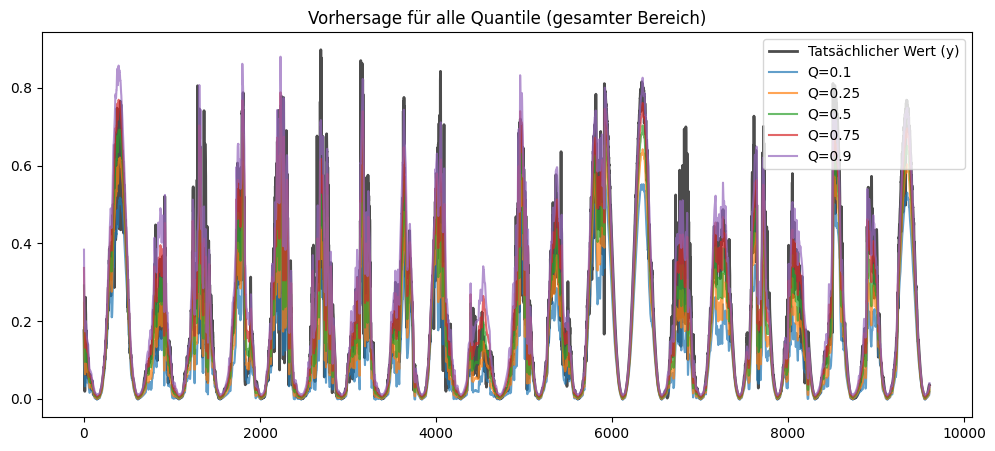

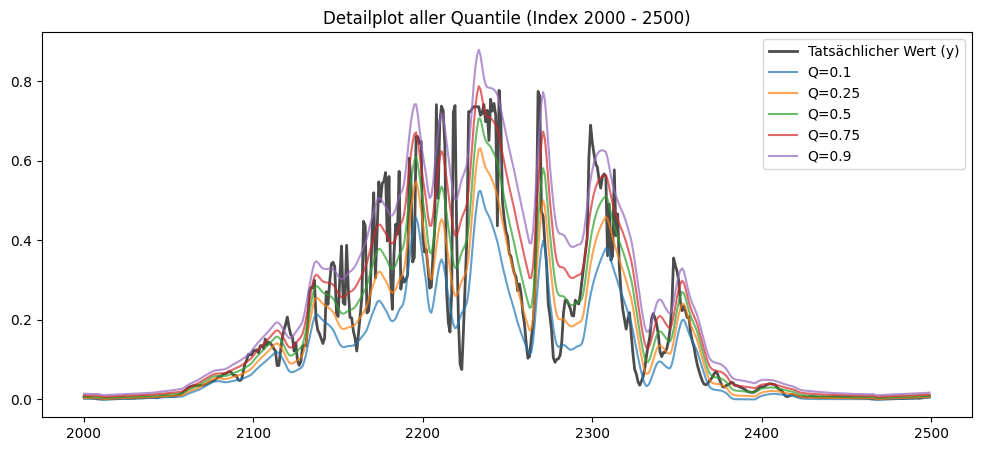

Metriken pro Quantil:
Quantil 0.1: MSE=0.0152, MAE=0.0836
Quantil 0.25: MSE=0.0080, MAE=0.0578
Quantil 0.5: MSE=0.0051, MAE=0.0439
Quantil 0.75: MSE=0.0050, MAE=0.0429
Quantil 0.9: MSE=0.0087, MAE=0.0581


In [29]:
compare_model_output_all_quantiles(
    model= best_model,
    X_test=X_test_seq,
    y_test_list=y_test_list,
    quantiles=quantiles,
    plot_indices=(2000, 2500)  # Beispielhafter Index-Bereich fürs Detailplot
)

In [26]:
def check_quantile_violations(model, X_test, y_test_seq):
    """
    Berechnet, wie oft die gemessenen Werte (y_true) das 10%- und 25%-Quantil unterschreiten,
    sowie das 75%- und 90%-Quantil überschreiten. Gibt außerdem die prozentualen Anteile
    (bezogen auf alle Datenpunkte) zurück.

    Parameter:
    ----------
    model       : Keras Multi-Head-Quantile-Modell
    X_test      : numpy-Array (N, sequence_length, num_features)
    y_test_seq  : numpy-Array (N, 5) oder (N, 1), in der Regel getiled,
                  so dass in jeder Spalte der gleiche true-Wert steht.

    Rückgabe:
    ----------
    dict
        Dictionary mit absoluten Anzahlen und prozentualen Anteilen.
    """

    # 1) Echte Y-Werte (1D) extrahieren:
    #    Wenn y_test_seq.shape == (N, 5), ist jede Spalte identisch.
    #    Wir nehmen einfach die erste Spalte als "wahren Wert".
    y_true = y_test_seq[:, 0]

    # 2) Vorhersagen vom Multi-Head-Modell abrufen (Liste aus 5 Arrays)
    pred_list = model.predict(X_test)
    # pred_list z.B. = [ array(N,1), array(N,1), array(N,1), array(N,1), array(N,1) ]
    # Die Reihenfolge entspricht den Quantilen [0.1, 0.25, 0.5, 0.75, 0.9]

    # 3) Zu einer 2D-Matrix (N, 5) zusammenführen (spaltenweise)
    y_pred_2d = np.hstack(pred_list)  # shape (N, 5)
    # Spalten: [q10, q25, q50, q75, q90]

    # 4) Quantile interpretieren
    #    y_pred_2d[:, 0] => 10%-Quantil
    #    y_pred_2d[:, 1] => 25%-Quantil
    #    y_pred_2d[:, 2] => 50%-Quantil
    #    y_pred_2d[:, 3] => 75%-Quantil
    #    y_pred_2d[:, 4] => 90%-Quantil

    n = len(y_true)  # Gesamtzahl der Datenpunkte

    # 5) Absolutzahlen für Verletzungen berechnen
    below_10p = np.sum(y_true < y_pred_2d[:, 0])
    below_25p = np.sum(y_true < y_pred_2d[:, 1])
    above_75p = np.sum(y_true > y_pred_2d[:, 3])
    above_90p = np.sum(y_true > y_pred_2d[:, 4])

    # 6) Prozentsätze berechnen
    below_10p_pct = (below_10p / n) * 100
    below_25p_pct = (below_25p / n) * 100
    above_75p_pct = (above_75p / n) * 100
    above_90p_pct = (above_90p / n) * 100

    return {
        'below_10_percentile': {
            'count': below_10p,
            'percentage': below_10p_pct
        },
        'below_25_percentile': {
            'count': below_25p,
            'percentage': below_25p_pct
        },
        'above_75_percentile': {
            'count': above_75p,
            'percentage': above_75p_pct
        },
        'above_90_percentile': {
            'count': above_90p,
            'percentage': above_90p_pct
        }
    }

In [30]:
results = check_quantile_violations(best_model, X_test_seq, y_test_seq)

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [31]:
results

{'below_10_percentile': {'count': 493, 'percentage': 5.131140716069941},
 'below_25_percentile': {'count': 1654, 'percentage': 17.21482098251457},
 'above_75_percentile': {'count': 3846, 'percentage': 40.029142381348876},
 'above_90_percentile': {'count': 1812, 'percentage': 18.859283930058286}}